# Analyze network balance with frustration index an algebraic conflict

In [1]:
import networkx as nx
import pandas as pd
from matplotlib import pyplot as plt
import tqdm
import os
from tqdm import tqdm
import glob
import re

import sys
sys.path.append('../local/bin/')

from sygno.signed_networkx import draw_signed_networkx

____________________

Retrieve Clausen and Peltzman categories

In [2]:
dataset_folder = '../dataset/'
congress_path = dataset_folder + 'download_votes_merged/*'

In [3]:
# Initialize a weighted bipartite graph
G = nx.Graph()

# Iterate through each CSV file
for csv_file in tqdm(glob.glob(congress_path)):
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(csv_file)
    
    # Count the occurrences of each pair of Clausen and Peltzman categories
    counts = df.groupby(["Clausen", "Peltzman"]).size().reset_index(name="count")
    
    # Add edges to the graph with weights based on the counts
    for _, row in counts.iterrows():
        clausen_category = row["Clausen"]
        peltzman_category = row["Peltzman"]
        count = row["count"]
        
        G.add_node(clausen_category, bipartite=0)
        G.add_node(peltzman_category, bipartite=1)
        G.add_edge(clausen_category, peltzman_category, weight=count)

# Now you have a weighted bipartite graph (G) with edges representing the co-occurrences
# between Clausen and Peltzman categories and weights representing the number of occurrences.

  0%|          | 0/41 [00:00<?, ?it/s]

  5%|▍         | 2/41 [00:02<00:59,  1.53s/it]/tmp/ipykernel_27648/3165551236.py:7: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)
100%|██████████| 41/41 [00:49<00:00,  1.20s/it]


In [4]:
print('Clausen categories: ', [n for n in G.nodes() if G.nodes[n]['bipartite'] == 0])
print('Number of Clausen categories: ', len([n for n in G.nodes() if G.nodes[n]['bipartite'] == 0]))

print('Peltzman categories: ', [n for n in G.nodes() if G.nodes[n]['bipartite'] == 1])
print('Number of Peltzman categories: ', len([n for n in G.nodes() if G.nodes[n]['bipartite'] == 1]))

Clausen categories:  ['Agriculture', 'Civil Liberties', 'Foreign and Defense Policy', 'Government Management', 'Miscellaneous Policy', 'Social Welfare']
Number of Clausen categories:  6
Peltzman categories:  ['Budget Special Interest', 'Regulation General Interest', 'Regulation Special Interest', 'D. C.', 'Domestic Social Policy', 'Defense Policy Budget', 'Defense Policy Resolutions', 'Foreign Policy Budget', 'Foreign Policy Resolutions', 'Budget General Interest', 'Government Organization', 'Internal Organization', 'Indian Affairs']
Number of Peltzman categories:  13


In [5]:
clausen_cat_list = [n for n in G.nodes() if G.nodes[n]['bipartite'] == 0]
peltzman_cat_list = [n for n in G.nodes() if G.nodes[n]['bipartite'] == 1]

clausen_cat_dic = {x: re.sub(' ', '_', x) for x in clausen_cat_list}
peltzman_cat_dic = {x: re.sub(' ', '_', x) for x in peltzman_cat_list}

_________________________

Load the dataframe created in the *data_parsing.ipynb* containing all the information about the members of the congresses

In [6]:
pol = pd.read_csv(dataset_folder + 'members.csv')
pol['color'] = pol['party_name'].apply(lambda x: 'firebrick' if 'Republican' in x else ('royalblue' if 'Democrat' in x else 'yellow'))

Create a dictionary that links each icpsr to a party. Notice that an icpsr identifies uniquely a legislator, but a legislator can have more than one icpsr. This is because the icpsr is assigned to a legislator for each congress. For example, if a legislator is elected in 2000 and reelected in 2002, he will have two different icpsr, one for each congress. We will use the icpsr of the first congress in which the legislator was elected.

In [7]:
pol_dic = pol[['icpsr', 'party_name']].set_index('icpsr').to_dict(orient="index")
# e.g.
pol_dic[323]

{'party_name': "['Democrat-Republican']"}

In [8]:
def draw_graph(df, pol_dic):

    # Arguments:
	# df ---> edgelist
	# pol_dic ---> dictionary where key is icpsr and value is party_name
	# congress_num ---> congress number

    G = nx.from_pandas_edgelist(df, 'source', 'target', ['weight'])

    nodeData = {list(g.icpsr)[0]: {'state': list(g.state_abbrev)[0], 'party': list(g.party_name)[0], 'color': list(g.color)[0],  'congress': list(g.congress)[0], 'name': list(g.bioname)[0]} for k, g in pol.groupby('icpsr')}
    nx.set_node_attributes(G, nodeData)

    colors = [node[1]['color'] for node in G.nodes(data=True)]
    
    fig, ax, pos, least_eigenvalue = draw_signed_networkx(G, node_color=colors, compact = True, theme="white", normalize=True, scale='log', jittering=0.01, margin=0.2, show_rotation=False, highlight_edges='frustrated', remove_n_outliers=3, sort_by='party')
    
    # print infos about users per party
    positions_party = {'pos': {'Democrat': 0,'Republican':0}, 'neg': {'Democrat': 0,'Republican':0}}
    for p in pos.keys():
        if pos[p].x > 0:
            if pol_dic[int(p)]['party_name'] == 'Democrat' or pol_dic[int(p)]['party_name'] == 'Republican':
                positions_party['pos'][pol_dic[int(p)]['party_name']] += 1
        else:
            if pol_dic[int(p)]['party_name'] == 'party_name' or pol_dic[int(p)]['party_name'] == 'Republican':
                positions_party['neg'][pol_dic[int(p)]['party_name']] += 1

    plt.text(0, .04, "Rep: "+str(positions_party['neg']['Republican']), fontsize=13, transform=ax.transAxes, color="ghostwhite")
    plt.text(0, .09, "Dem: "+str(positions_party['neg']['Democrat']), fontsize=13, transform=ax.transAxes, color="ghostwhite")

    plt.text(0.9, .04, "Rep: "+str(positions_party['pos']['Republican']), fontsize=13, transform=ax.transAxes, color="ghostwhite")
    plt.text(0.9, .09, "Dem: "+str(positions_party['pos']['Democrat']), fontsize=13, transform=ax.transAxes, color="ghostwhite")
    

    plt.show()

    return least_eigenvalue

In [9]:
def read_edgelist(folder, threshold_pos, threshold_neg):
    # read edgelist
    df = pd.read_csv(folder)
    df_pos = df.loc[(df['weight']==1)&(df['perc']>threshold_pos)].copy()
    df_neg = df.loc[(df['weight']==-1)&(df['perc']>threshold_neg)].copy()
    df = pd.concat([df_pos, df_neg])
    

    least_eigen = draw_graph(df, pol_dic)

    return least_eigen

In [10]:
thresholds_path = '../dataset/thresholds/'
edgelists_path = '../dataset/edgelists/'

_______________________________________________________________

## Compute the Algebraic Conflict
##### i.e. the smallest eigenvalue of the (signed) Laplacian matrix

In [13]:
from sygno.nodes_position import _get_xcoord

In [14]:
def compute_eigen(df):
    def compute_d_max(G):
        max_d = 0
        for edge in G.edges(data=True):
            temp = G.degree[edge[0]] + G.degree[edge[1]]
            if temp > max_d:
                max_d = temp
        return max_d / 2

    G = nx.from_pandas_edgelist(df, 'source', 'target', ['weight'])
    df, least_eigenvalue = _get_xcoord(G, compact=False)
    max_d = compute_d_max(G)
    eig = 1-(least_eigenvalue/(max_d-1))
    return eig

In [15]:
def read_edgelist_eigen(folder, threshold_pos, threshold_neg):
    # read edgelist
    df = pd.read_csv(folder)
    df_pos = df.loc[(df['weight']==1)&(df['perc']>threshold_pos)].copy()
    df_neg = df.loc[(df['weight']==-1)&(df['perc']>threshold_neg)].copy()
    df = pd.concat([df_pos, df_neg])

    return compute_eigen(df)

  0%|          | 0/6 [00:00<?, ?it/s]

Generating plot for:  Agriculture


 17%|█▋        | 1/6 [00:44<03:42, 44.43s/it]

Generating plot for:  Civil_Liberties


 33%|███▎      | 2/6 [01:26<02:51, 42.79s/it]

Generating plot for:  Foreign_and_Defense_Policy


 50%|█████     | 3/6 [02:12<02:13, 44.66s/it]

Generating plot for:  Government_Management


 67%|██████▋   | 4/6 [03:00<01:31, 45.78s/it]

Generating plot for:  Miscellaneous_Policy


 83%|████████▎ | 5/6 [03:44<00:44, 44.99s/it]

Generating plot for:  Social_Welfare


100%|██████████| 6/6 [04:31<00:00, 45.27s/it]


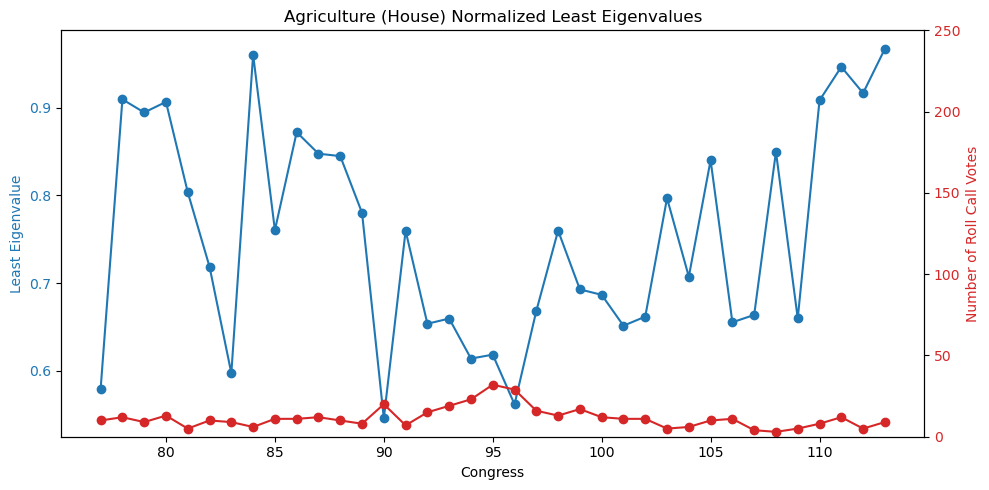

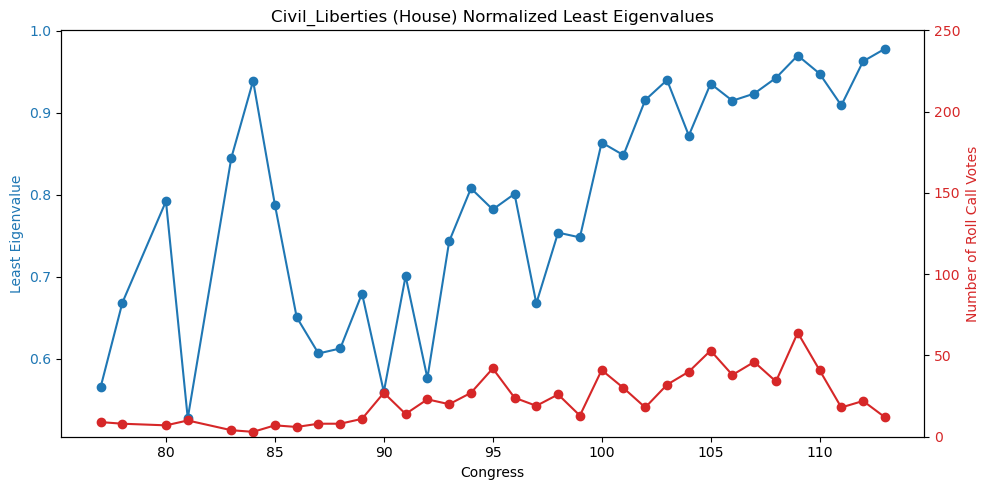

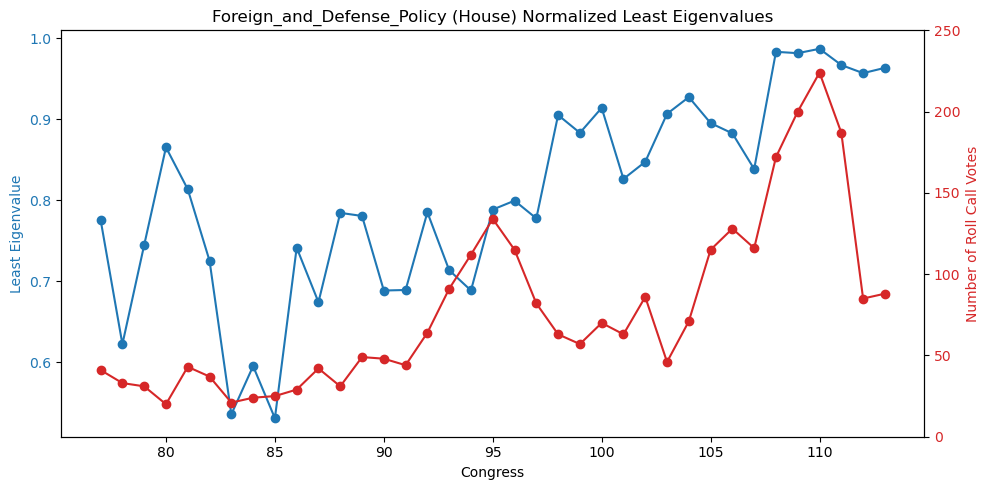

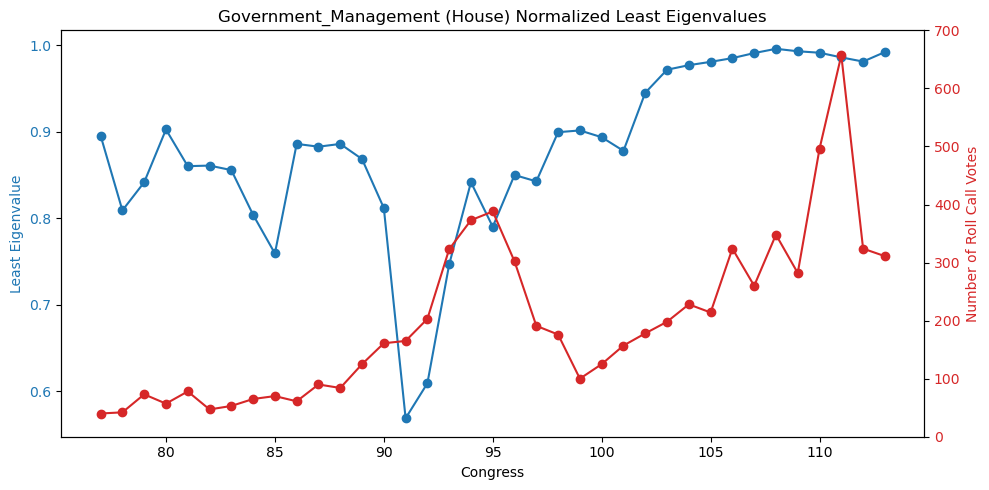

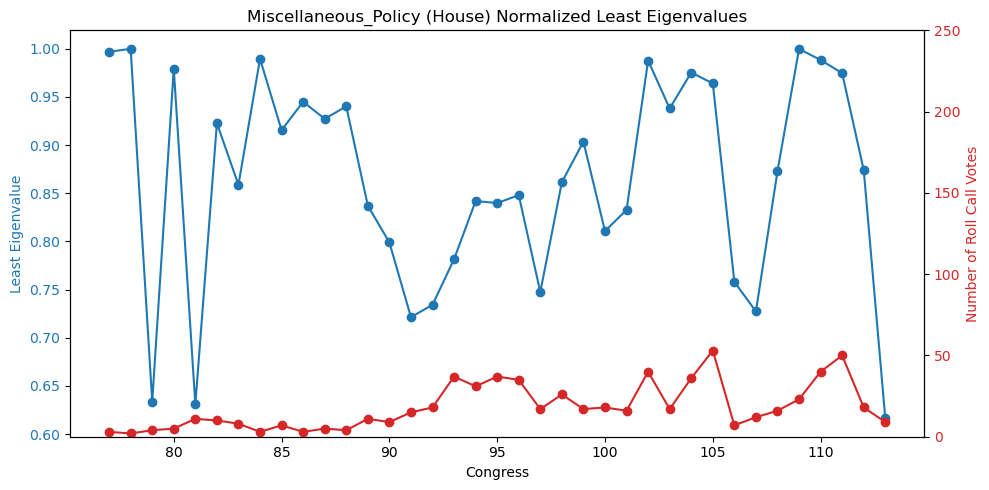

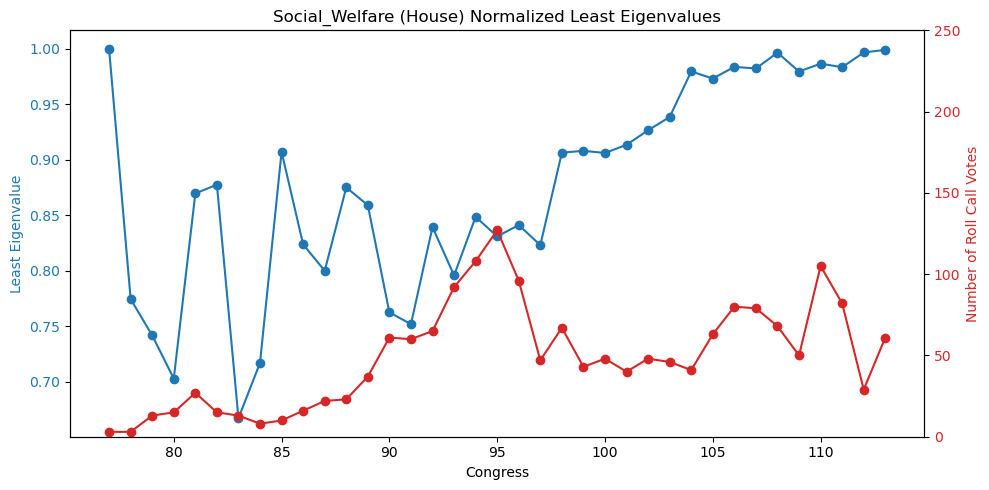

In [16]:
for clausen in tqdm(clausen_cat_dic.values()):

	print("Generating plot for: ", clausen)

	eigenvalues = {}
	n_votes_dict = {}  # Dictionary to store the number of votes for each congress


	for csv in tqdm(glob.glob(edgelists_path + 'votes_house_clausen_edges/' + clausen + '/*.csv')):
		n_congress = int(os.path.basename(csv).replace('congress_', '').replace('.csv', ''))

		#check if the threshold file exists, otherwise continue
		if not os.path.exists(thresholds_path + 'house_clausen_thresholds/' + clausen + '/' + str(n_congress) + '_dic_thresholds_norm.csv'):
			continue

		# Rest of your existing code to compute eigenvalues
		temp = pd.read_csv(thresholds_path + 'house_clausen_thresholds/' + clausen + '/' + str(n_congress) + '_dic_thresholds_norm.csv')
		threshold_pos = temp.iloc[0]['pos_threshold']
		threshold_neg = temp.iloc[0]['neg_threshold']
		n_votes = temp.iloc[0]['n_votes']  # Read the 'n_votes' column
		n_votes_dict[n_congress] = n_votes  # Store the number of votes

		# Read the CSV file into a pandas DataFrame
		df = pd.read_csv(csv)
		df_pos = df.loc[(df['weight']==1)&(df['perc']>threshold_pos)].copy()
		df_neg = df.loc[(df['weight']==-1)&(df['perc']>threshold_neg)].copy()
		df = pd.concat([df_pos, df_neg])

		# Create a graph from the DataFrame
		G = nx.from_pandas_edgelist(df, 'source', 'target')

		# check if df is empty
		if df.empty:
			continue
		else:
			# Check if the graph is connected
			if not nx.is_connected(G):
			# If the graph is not connected, continue to the next iteration
				continue

		least_eigevalue = read_edgelist_eigen(csv, threshold_pos, threshold_neg)
		eigenvalues[n_congress] = least_eigevalue
	
	# Plot the eigenvalues on the left y-axis
	congress_list = sorted(eigenvalues.keys())
	eigenvalue_list = [eigenvalues[x] for x in congress_list]

	fig, ax1 = plt.subplots(figsize=(10, 5))

	color = 'tab:blue'
	ax1.set_xlabel('Congress')
	ax1.set_ylabel('Least Eigenvalue', color=color)
	ax1.plot(congress_list, eigenvalue_list, 'o-', color=color)
	ax1.tick_params(axis='y', labelcolor=color)

	# Create a second y-axis
	ax2 = ax1.twinx()

	n_votes_list = [n_votes_dict[x] for x in congress_list]
	color = 'tab:red'
	ax2.set_ylabel('Number of Roll Call Votes', color=color)
	ax2.plot(congress_list, n_votes_list, 'o-', color=color)
	ax2.tick_params(axis='y', labelcolor=color)
	if clausen == 'Government_Management':
		ax2.set_ylim([0, 700])
	else:
		ax2.set_ylim([0, 250])

	ouput = '../plots/norm_least_eigenvalues/house_clausen/' + str(clausen) + '_nle.png'

	# set title
	plt.title(clausen + ' (House) Normalized Least Eigenvalues')

	fig.tight_layout()
	plt.savefig(ouput)


100%|██████████| 6/6 [00:15<00:00,  2.58s/it]


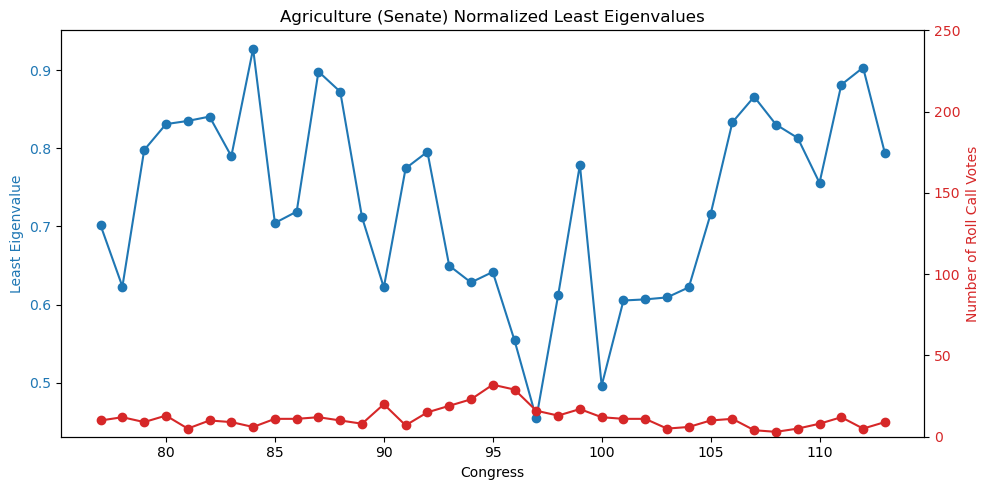

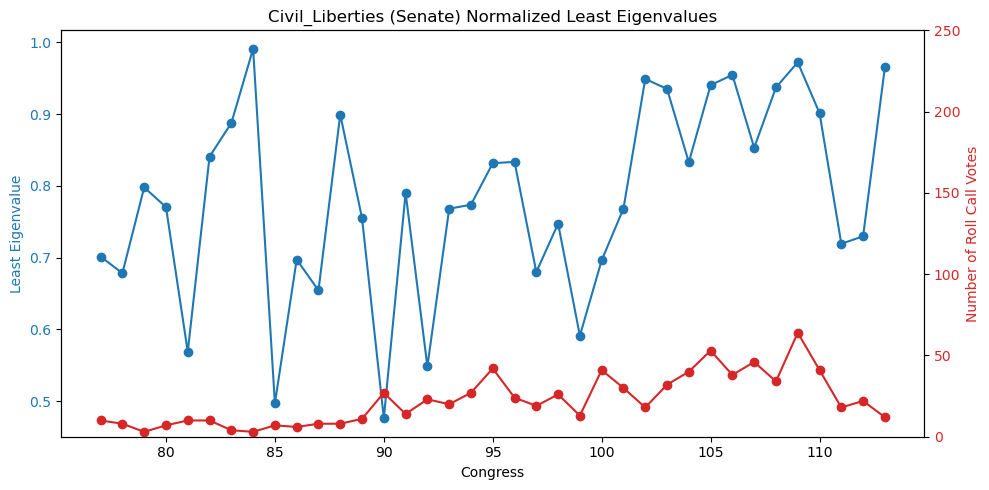

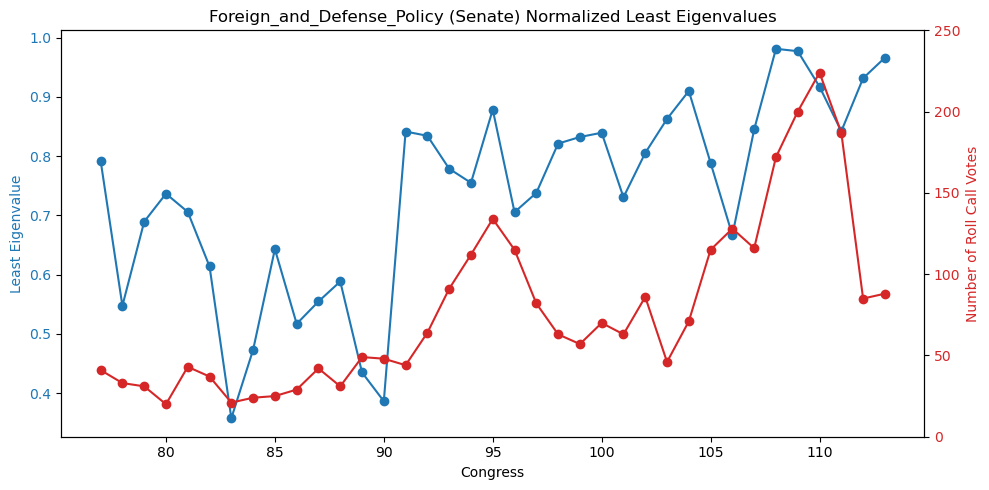

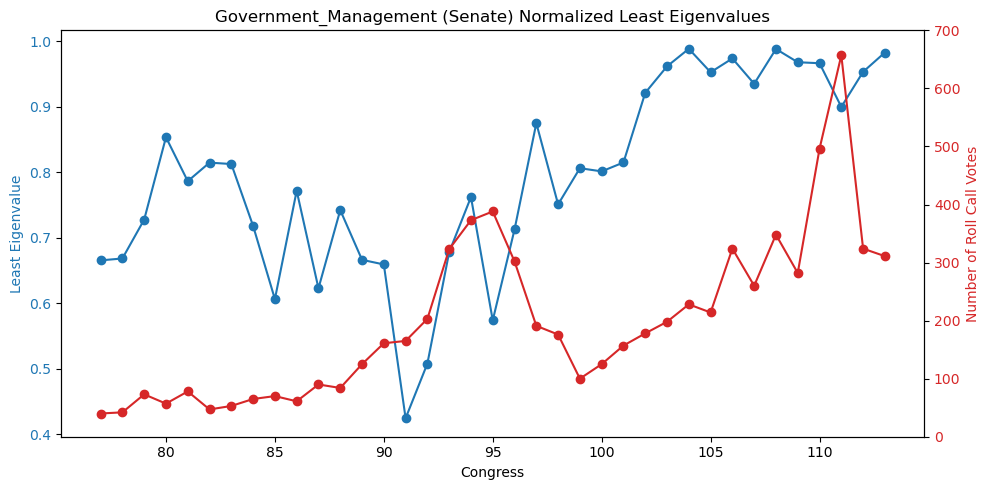

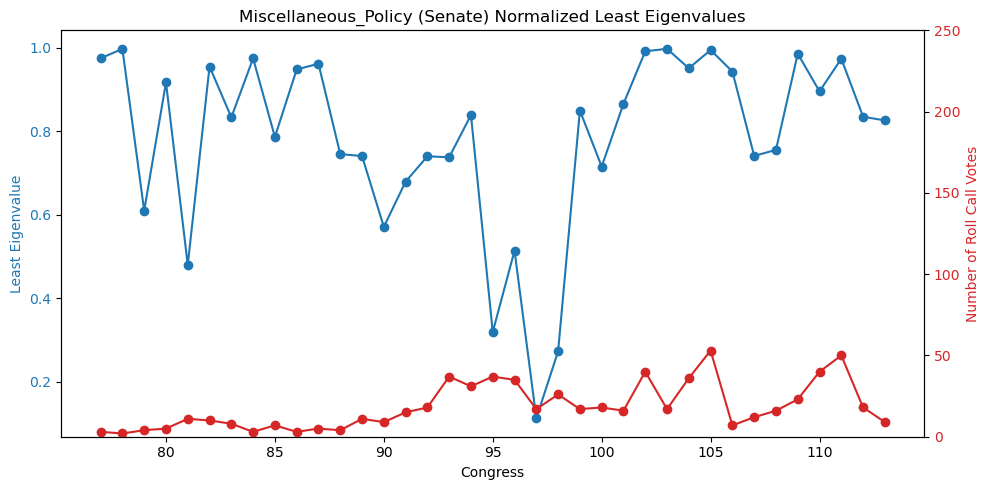

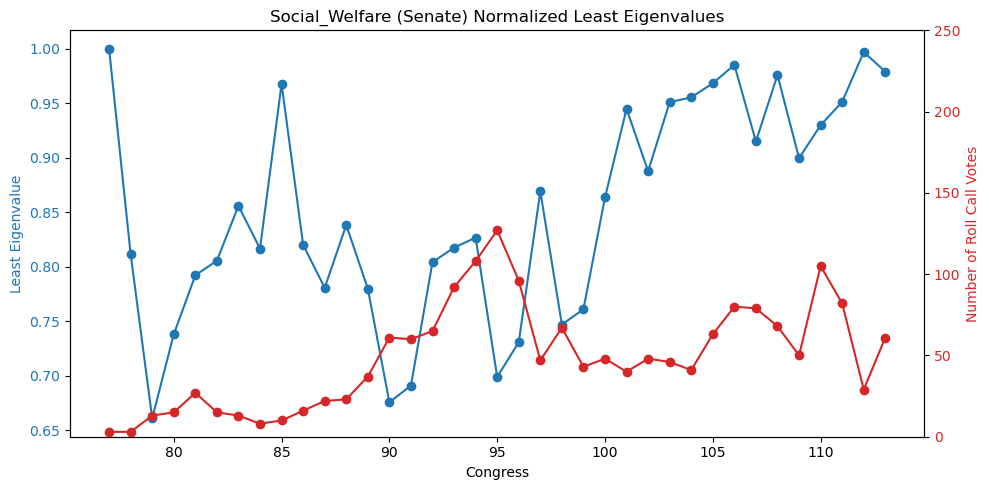

In [40]:
for clausen in tqdm(clausen_cat_dic.values()):

	print("Generating plot for: ", clausen)

	eigenvalues = {}
	n_votes_dict = {}  # Dictionary to store the number of votes for each congress


	for csv in tqdm(glob.glob(edgelists_path + 'votes_senate_clausen_edges/' + clausen + '/*.csv')):
		n_congress = int(os.path.basename(csv).replace('congress_', '').replace('.csv', ''))

		#check if the threshold file exists, otherwise continue
		if not os.path.exists(thresholds_path + 'house_clausen_thresholds/' + clausen + '/' + str(n_congress) + '_dic_thresholds_norm.csv'):
			continue

		# Rest of your existing code to compute eigenvalues
		temp = pd.read_csv(thresholds_path + 'house_clausen_thresholds/' + clausen + '/' + str(n_congress) + '_dic_thresholds_norm.csv')
		threshold_pos = temp.iloc[0]['pos_threshold']
		threshold_neg = temp.iloc[0]['neg_threshold']
		n_votes = temp.iloc[0]['n_votes']  # Read the 'n_votes' column
		n_votes_dict[n_congress] = n_votes  # Store the number of votes

		# Read the CSV file into a pandas DataFrame
		df = pd.read_csv(csv)
		df_pos = df.loc[(df['weight']==1)&(df['perc']>threshold_pos)].copy()
		df_neg = df.loc[(df['weight']==-1)&(df['perc']>threshold_neg)].copy()
		df = pd.concat([df_pos, df_neg])

		# Create a graph from the DataFrame
		G = nx.from_pandas_edgelist(df, 'source', 'target')

		# check if df is empty
		if df.empty:
			continue
		else:
			# Check if the graph is connected
			if not nx.is_connected(G):
			# If the graph is not connected, continue to the next iteration
				continue

		least_eigevalue = read_edgelist_eigen(csv, threshold_pos, threshold_neg)
		eigenvalues[n_congress] = least_eigevalue

	# Plot the eigenvalues on the left y-axis
	congress_list = sorted(eigenvalues.keys())
	eigenvalue_list = [eigenvalues[x] for x in congress_list]

	fig, ax1 = plt.subplots(figsize=(10, 5))

	color = 'tab:blue'
	ax1.set_xlabel('Congress')
	ax1.set_ylabel('Least Eigenvalue', color=color)
	ax1.plot(congress_list, eigenvalue_list, 'o-', color=color)
	ax1.tick_params(axis='y', labelcolor=color)

	# Create a second y-axis
	ax2 = ax1.twinx()

	n_votes_list = [n_votes_dict[x] for x in congress_list]
	color = 'tab:red'
	ax2.set_ylabel('Number of Roll Call Votes', color=color)
	ax2.plot(congress_list, n_votes_list, 'o-', color=color)
	ax2.tick_params(axis='y', labelcolor=color)
	if clausen == 'Government_Management':
		ax2.set_ylim([0, 700])
	else:
		ax2.set_ylim([0, 250])

	ouput = '../plots/norm_least_eigenvalues/senate_clausen/' + str(clausen) + '_nle.png'

	# set title
	plt.title(clausen + ' (Senate) Normalized Least Eigenvalues')

	fig.tight_layout()
	plt.savefig(ouput)

  0%|          | 0/13 [00:00<?, ?it/s]

Generating plot for:  Budget_Special_Interest


  8%|▊         | 1/13 [00:37<07:30, 37.53s/it]

Generating plot for:  Regulation_General_Interest


 15%|█▌        | 2/13 [01:08<06:07, 33.40s/it]

Generating plot for:  Regulation_Special_Interest


 23%|██▎       | 3/13 [01:43<05:44, 34.41s/it]

Generating plot for:  D._C.


 31%|███       | 4/13 [02:04<04:21, 29.07s/it]

Generating plot for:  Domestic_Social_Policy


 38%|███▊      | 5/13 [02:41<04:13, 31.74s/it]

Generating plot for:  Defense_Policy_Budget


 46%|████▌     | 6/13 [03:20<03:59, 34.25s/it]

Generating plot for:  Defense_Policy_Resolutions


 54%|█████▍    | 7/13 [03:51<03:20, 33.34s/it]

Generating plot for:  Foreign_Policy_Budget


 62%|██████▏   | 8/13 [04:33<03:00, 36.10s/it]

Generating plot for:  Foreign_Policy_Resolutions


 69%|██████▉   | 9/13 [05:09<02:23, 35.91s/it]

Generating plot for:  Budget_General_Interest


 77%|███████▋  | 10/13 [05:50<01:52, 37.62s/it]

Generating plot for:  Government_Organization


 85%|████████▍ | 11/13 [06:30<01:16, 38.19s/it]

Generating plot for:  Internal_Organization


 92%|█████████▏| 12/13 [07:11<00:39, 39.16s/it]

Generating plot for:  Indian_Affairs


100%|██████████| 13/13 [07:25<00:00, 34.28s/it]


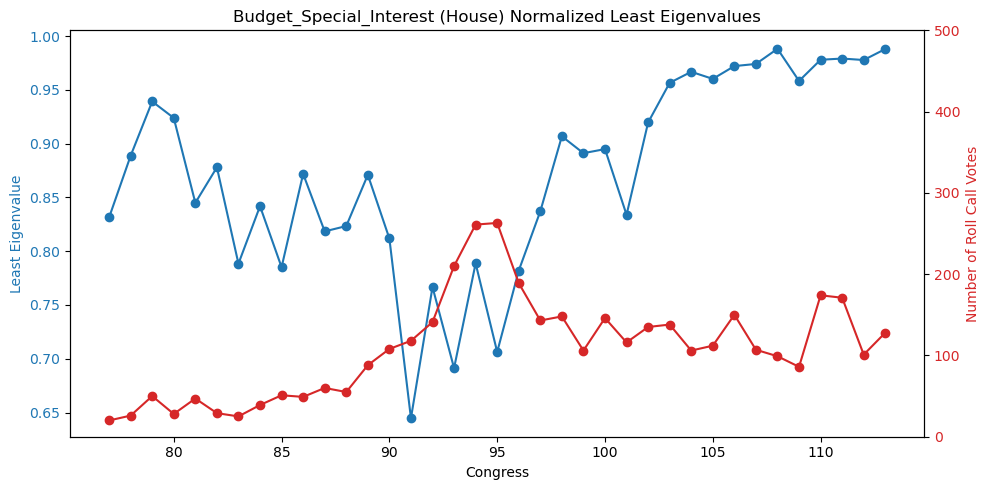

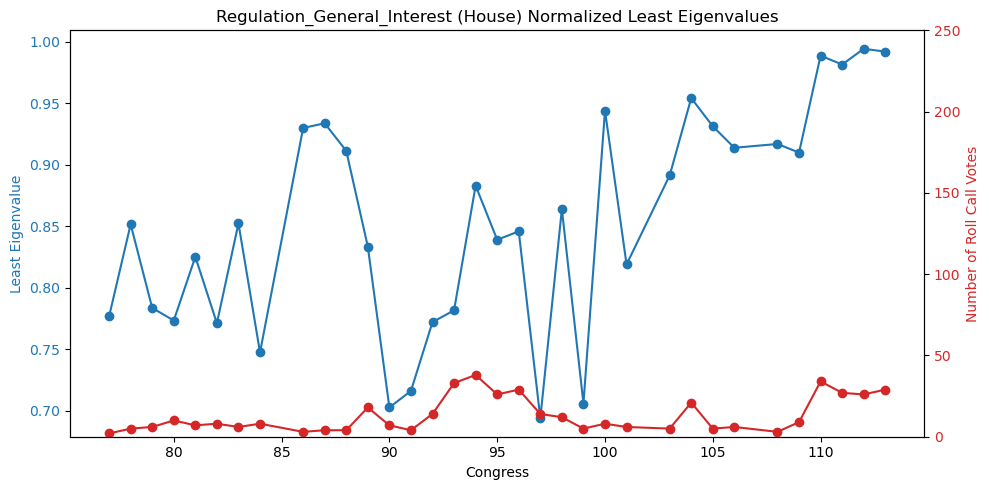

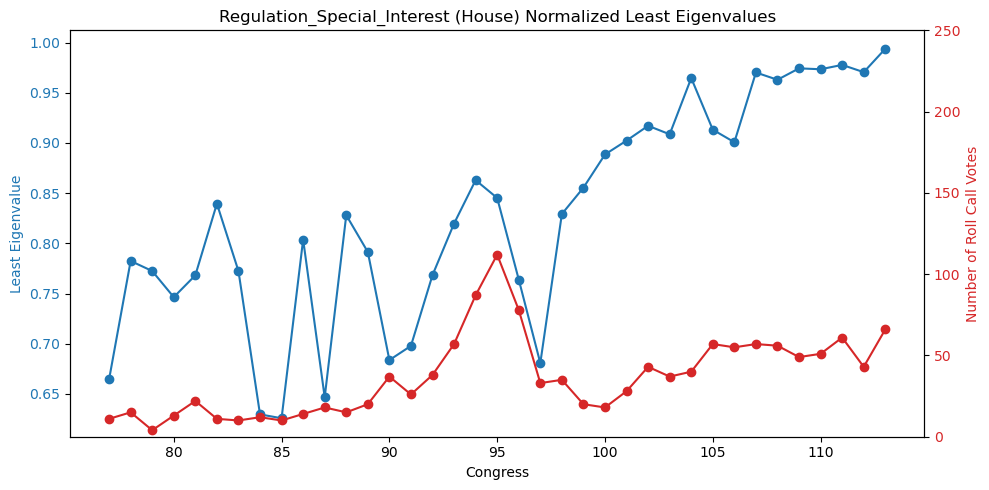

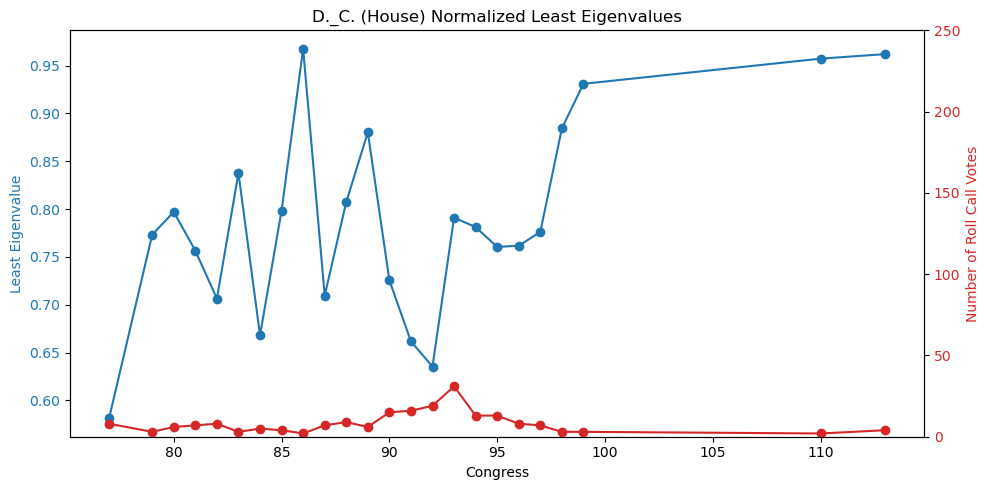

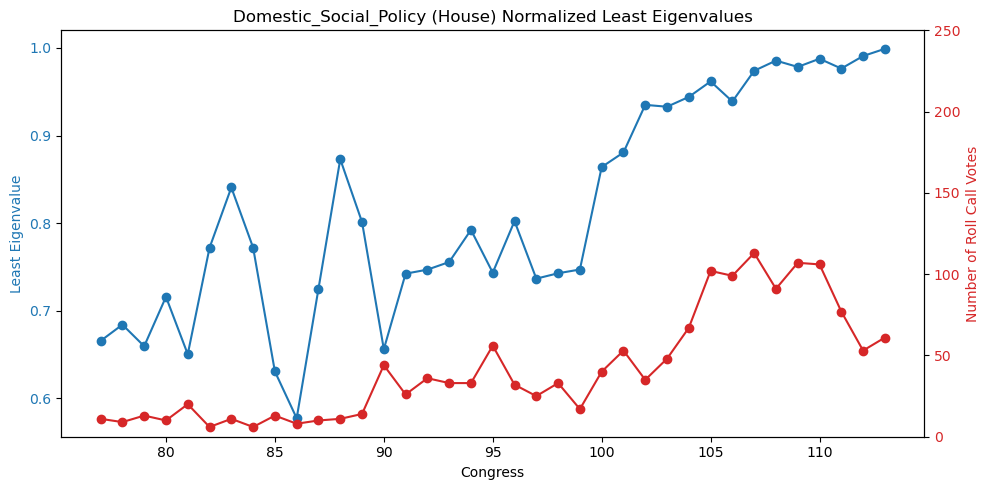

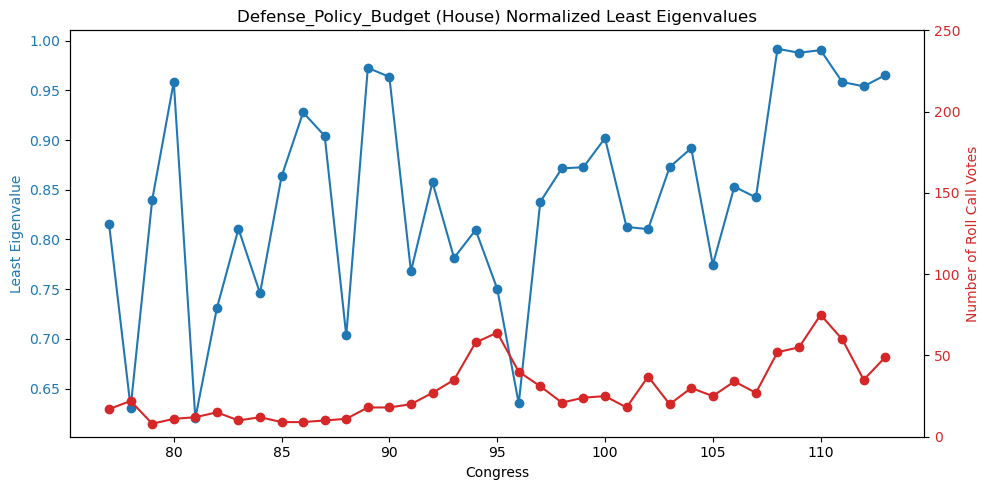

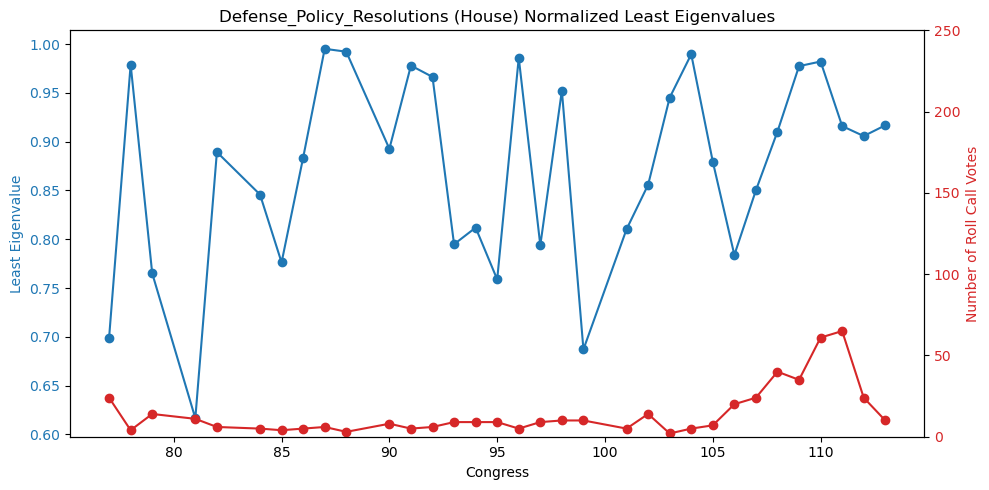

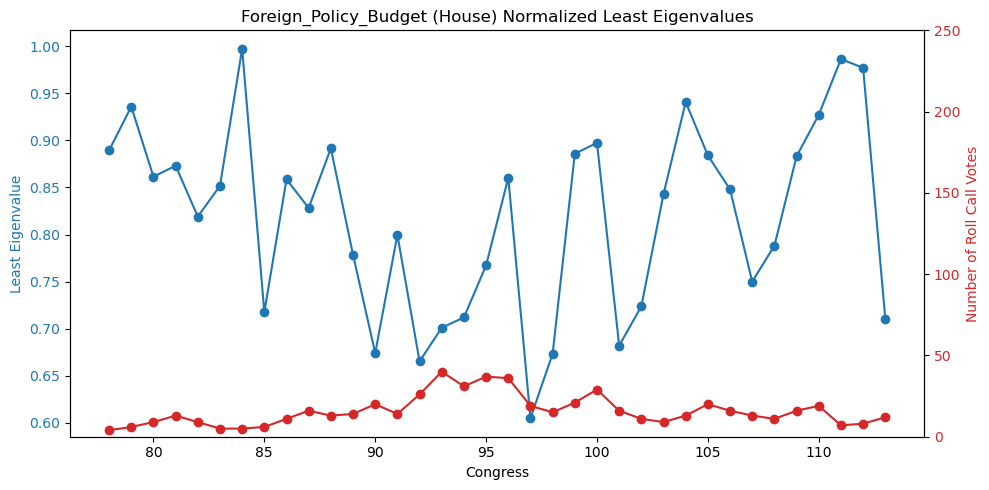

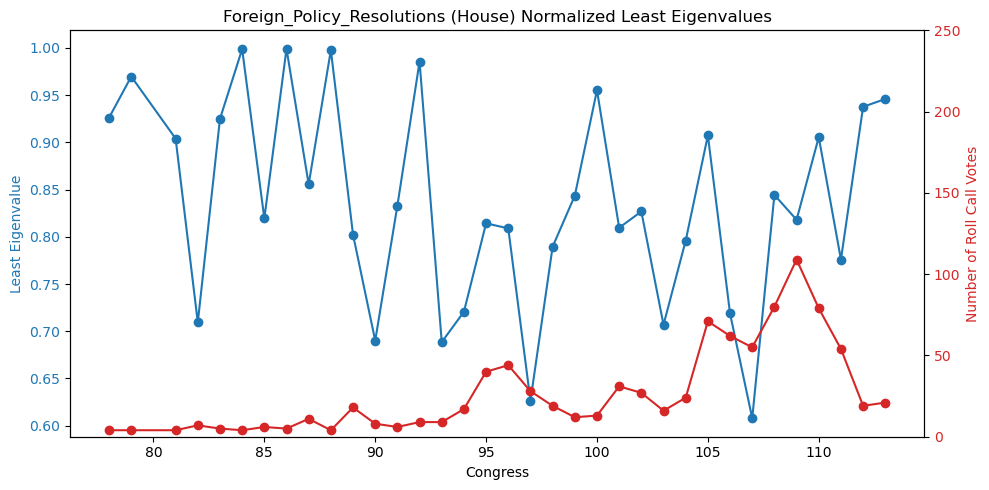

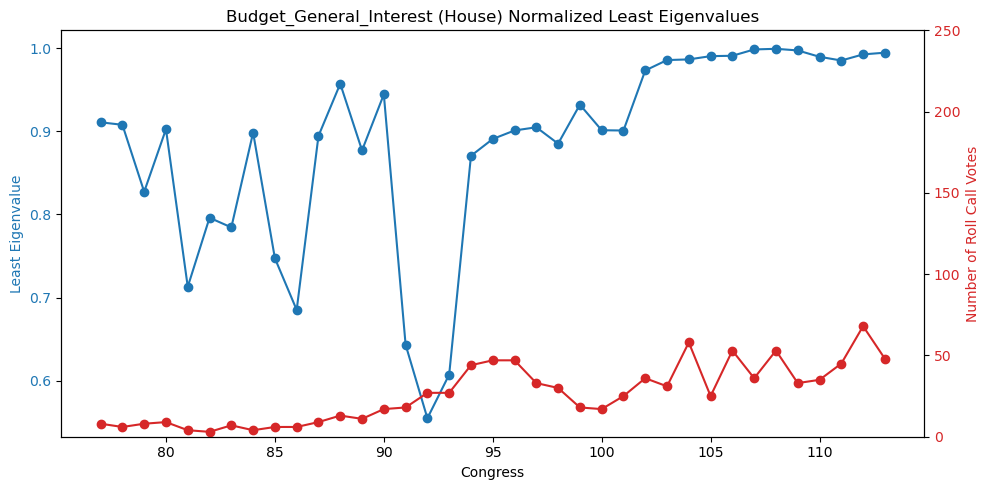

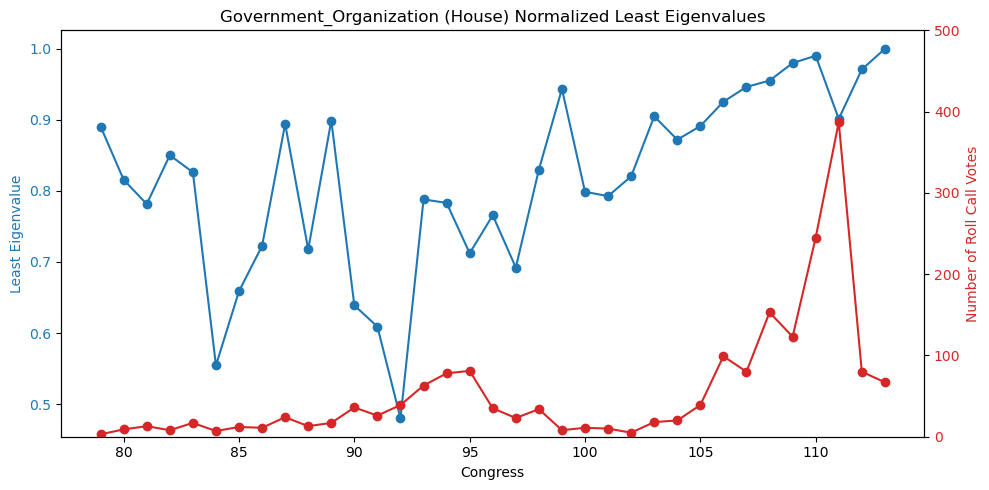

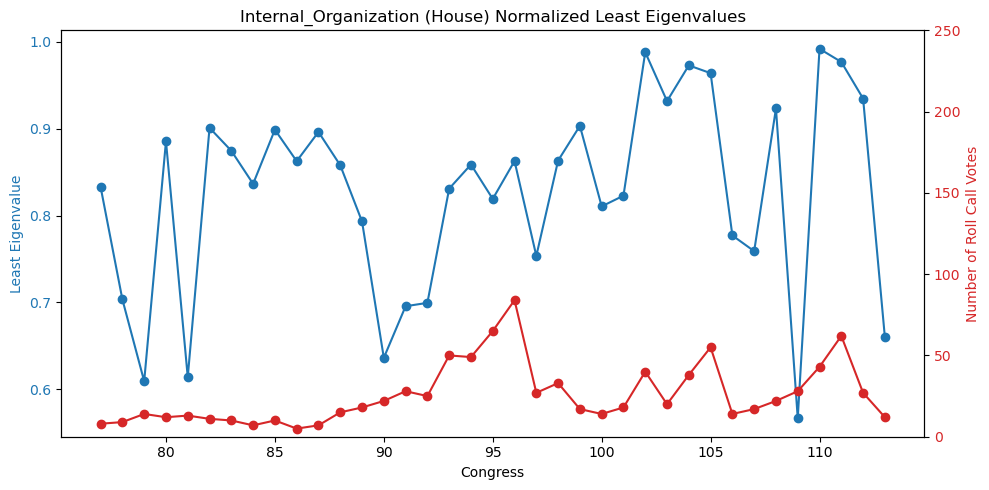

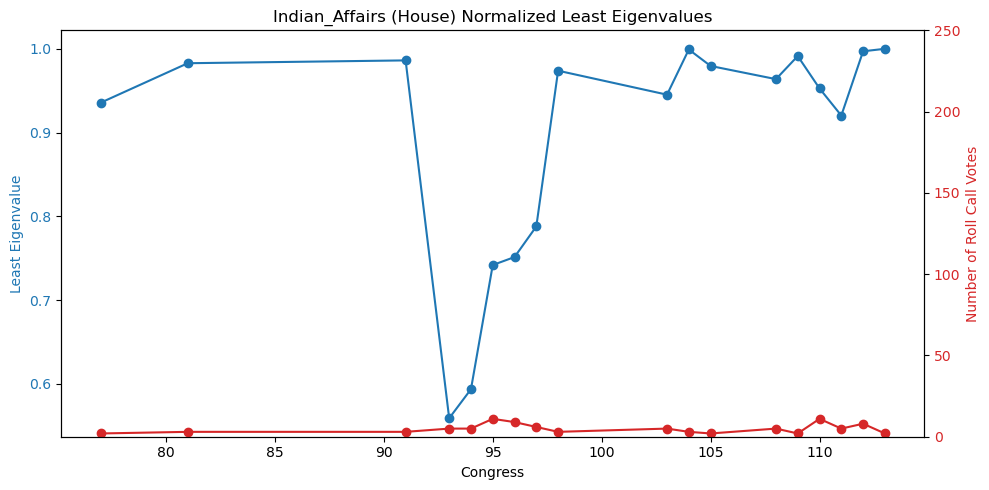

In [18]:
for peltzman in tqdm(peltzman_cat_dic.values()):

	print("Generating plot for: ", peltzman)

	eigenvalues = {}
	n_votes_dict = {}  # Dictionary to store the number of votes for each congress


	for csv in tqdm(glob.glob(edgelists_path + 'votes_house_peltzman_edges/' + peltzman + '/*.csv')):
		n_congress = int(os.path.basename(csv).replace('congress_', '').replace('.csv', ''))

		#check if the threshold file exists, otherwise continue
		if not os.path.exists(thresholds_path + 'house_peltzman_thresholds/' + peltzman + '/' + str(n_congress) + '_dic_thresholds_norm.csv'):
			continue

		# Rest of your existing code to compute eigenvalues
		temp = pd.read_csv(thresholds_path + 'house_peltzman_thresholds/' + peltzman + '/' + str(n_congress) + '_dic_thresholds_norm.csv')
		threshold_pos = temp.iloc[0]['pos_threshold']
		threshold_neg = temp.iloc[0]['neg_threshold']
		n_votes = temp.iloc[0]['n_votes']  # Read the 'n_votes' column
		n_votes_dict[n_congress] = n_votes  # Store the number of votes

		# Read the CSV file into a pandas DataFrame
		df = pd.read_csv(csv)
		df_pos = df.loc[(df['weight']==1)&(df['perc']>threshold_pos)].copy()
		df_neg = df.loc[(df['weight']==-1)&(df['perc']>threshold_neg)].copy()
		df = pd.concat([df_pos, df_neg])

		# Create a graph from the DataFrame
		G = nx.from_pandas_edgelist(df, 'source', 'target')

		# check if df is empty
		if df.empty:
			continue
		else:
			# Check if the graph is connected
			if not nx.is_connected(G):
			# If the graph is not connected, continue to the next iteration
				continue

		least_eigevalue = read_edgelist_eigen(csv, threshold_pos, threshold_neg)
		eigenvalues[n_congress] = least_eigevalue
	
	# Plot the eigenvalues on the left y-axis
	congress_list = sorted(eigenvalues.keys())
	eigenvalue_list = [eigenvalues[x] for x in congress_list]

	fig, ax1 = plt.subplots(figsize=(10, 5))

	color = 'tab:blue'
	ax1.set_xlabel('Congress')
	ax1.set_ylabel('Least Eigenvalue', color=color)
	ax1.plot(congress_list, eigenvalue_list, 'o-', color=color)
	ax1.tick_params(axis='y', labelcolor=color)

	# Create a second y-axis
	ax2 = ax1.twinx()

	n_votes_list = [n_votes_dict[x] for x in congress_list]
	color = 'tab:red'
	ax2.set_ylabel('Number of Roll Call Votes', color=color)
	ax2.plot(congress_list, n_votes_list, 'o-', color=color)
	ax2.tick_params(axis='y', labelcolor=color)
	if peltzman == 'Government_Organization' or peltzman == 'Budget_Special_Interest':
		ax2.set_ylim([0, 500])
	else:
		ax2.set_ylim([0, 250])

	ouput = '../plots/norm_least_eigenvalues/house_peltzman/' + str(peltzman) + '_nle.png'

	# set title
	plt.title(peltzman + ' (House) Normalized Least Eigenvalues')

	fig.tight_layout()
	plt.savefig(ouput)
